In [25]:
from tensorflow.keras.datasets import fashion_mnist
(x_train_full, y_train_full), (x_test_full, y_test_full) = fashion_mnist.load_data()
X_valid = x_train_full[:5000]
y_valid = y_train_full[:5000]
X_train = x_train_full[5000:]
y_train = y_train_full[5000:]


In [26]:
import numpy as np
X_train = np.expand_dims(X_train, axis=-1)
X_valid = np.expand_dims(X_valid, axis=-1)
X_test = np.expand_dims(x_test_full, axis=-1) 
X_train.shape

(55000, 28, 28, 1)

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_valid= X_valid / 255.0
print("Min:", X_train.min())
print("Max:", X_train.max())
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

Min: 0.0
Max: 1.0
(55000, 28, 28, 1)
(10000, 28, 28, 1)
(5000, 28, 28, 1)


In [20]:
import tensorflow as tf
from functools import partial

# Définir une version par défaut des couches Conv2D si besoin
DefaultConv2D=partial(tf.keras.layers.Conv2D, kernel_size=3, padding='same',
                      activation='relu', kernel_initializer='he_normal')

model = tf.keras.Sequential([
    # Bloc 1
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),

    # Bloc 2
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),

    # Bloc 3
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),

    # Dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')  # 10 classes Fashion MNIST
])

/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
from tensorflow.keras.optimizers import Adam
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
history=model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))
model.save('fashion_mnist.keras')

Epoch 1/3
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 287s 166ms/step - accuracy: 0.7026 - loss: 0.8193 - val_accuracy: 0.8574 - val_loss: 0.3911
Epoch 2/3
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 299s 174ms/step - accuracy: 0.8417 - loss: 0.4627 - val_accuracy: 0.8878 - val_loss: 0.3037
Epoch 3/3
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 292s 170ms/step - accuracy: 0.8698 - loss: 0.3840 - val_accuracy: 0.8940 - val_loss: 0.2962


In [28]:
from tensorflow import keras
model = keras.models.load_model("fashion_mnist.keras")
model.evaluate(X_test,y_test_full)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8885 - loss: 0.3130


[0.31300482153892517, 0.8884999752044678]

In [30]:
from build_embedding_model import load_embedding_model
embedding_model = load_embedding_model("fashion_mnist.keras")
embeddings_train = embedding_model.predict(X_train, batch_size=64)
np.save("embeddings_train.npy", embeddings_train)

860/860 ━━━━━━━━━━━━━━━━━━━━ 45s 52ms/step


In [31]:
from build_embedding_model import load_embedding_model
embedding_model = load_embedding_model("fashion_mnist.keras")
embeddings_test = embedding_model.predict(X_test, batch_size=64)
np.save("embeddings_test.npy", embeddings_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step


In [32]:
embeddings_train = np.load("embeddings_train.npy")
embeddings_test = np.load("embeddings_test.npy")
labels=y_train

In [35]:
i = 0  # par exemple la première image
query_image = X_test[i]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


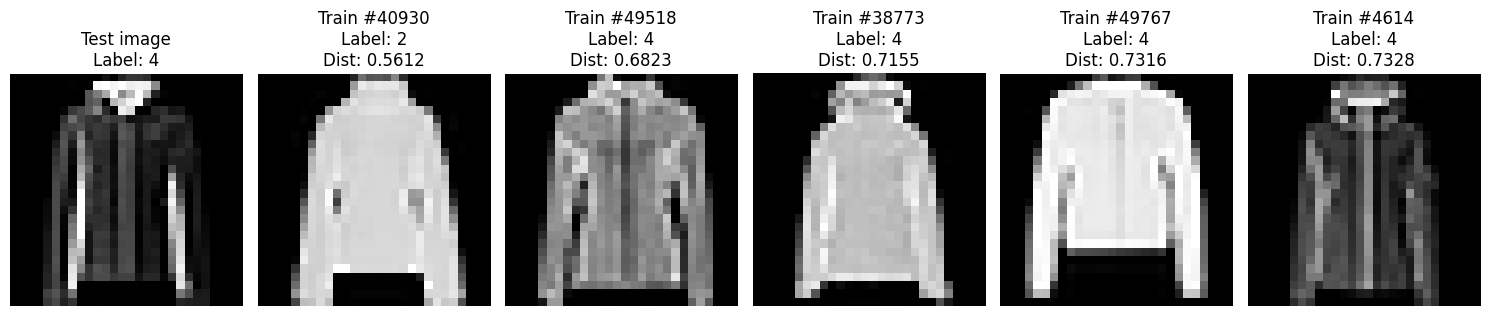

In [37]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

# Choisir une image de test
i = 6  # par exemple la première image
query_image = X_test[i]

# Générer son embedding
query_embedding = embedding_model.predict(np.expand_dims(query_image, axis=0))[0]

# Calculer les distances euclidiennes avec les embeddings de X_train
distances = norm(embeddings_train - query_embedding, axis=1)

# Indices des 5 plus proches voisins
top_k_indices = np.argsort(distances)[:5]

# Afficher l’image requête + les 5 plus proches voisins
plt.figure(figsize=(15, 3))

# Afficher l’image requête
plt.subplot(1, 6, 1)
img = query_image.squeeze()
plt.imshow(img, cmap='gray')
plt.title(f"Test image\nLabel: {y_test[i]}")
plt.axis('off')

# Afficher les 5 plus proches images d'entraînement
for j, idx in enumerate(top_k_indices):
    plt.subplot(1, 6, j + 2)
    img = X_train[idx].squeeze()
    label = y_train[idx]
    dist = distances[idx]
    plt.imshow(img, cmap='gray')
    plt.title(f"Train #{idx}\nLabel: {label}\nDist: {dist:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from numpy.linalg import norm

def find_top_k_closest(embeddings, query_embedding, paths, labels, k=5):
    distances = norm(embeddings - query_embedding, axis=1)
    top_k_indices = np.argsort(distances)[:k]
    return [(paths[i], labels[i], distances[i]) for i in top_k_indices]

In [ ]:

top_k_results = find_top_k_closest(embeddings, query_embedding, paths, labels, k=5)
for path, label, dist in top_k_results:
    print(f"Image: {path}, Label: {label}, Distance: {dist:.4f}")